In [1]:
import numpy as np
import pandas as pd
from tsfresh import feature_extraction
import os
import seaborn as sns
import re
from collections import defaultdict

In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

In [3]:
def normalize_signal(signal):
    """
    time_series
    
    Returns normalized TS: (TS - mean(TS))/std(TS)
    """
    std = np.std(signal)
    norm_signal = (signal - np.mean(signal)) / std if std else 1
    return norm_signal

In [4]:
def normalize_all_signals_in_ds(one_group_ds):
    for signal in one_group_ds.drop('t', axis=1):
        one_group_ds[signal] = normalize_signal(one_group_ds[signal])

In [5]:
# os.chdir('..')
os.getcwd()

'/Users/aolen/master_degree'

In [6]:
# labels = pd.DataFrame(columns=['id', 'class', 'label'])
# labels.columns
# labels.append((pd.Series( [1, 2, 3], index=labels.columns)), ignore_index=True)
# # dfObj.append(pd.Series(['Raju', 21, 'Bangalore', 'India'], index=dfObj.columns ), ignore_index=True)

In [7]:
def append_signals_dataset(data_directory, signals_dataset = None, labels = None):
    data_dir_list = os.listdir(data_directory)
    os.chdir(data_directory)
    signal_id = 0
    if not labels:
        labels = pd.DataFrame(columns=['id', 'class', 'label'])
    for signal_label, directory in enumerate(data_dir_list):
        if os.path.isfile(directory) or directory[0] == '.':
                continue
        os.chdir(directory)
        for filename in os.listdir(os.curdir):
            if re.match(r'(.*csv)', filename):
                if (signals_dataset) is not None:
                    tmp_df = pd.read_csv(filename)
                    normalize_all_signals_in_ds(tmp_df)
                    tmp_df['id'] = signal_id
                    signals_dataset = signals_dataset.append(tmp_df, ignore_index=True)
                else:
                    signals_dataset = pd.read_csv(filename)
                    normalize_all_signals_in_ds(signals_dataset)
                    signals_dataset['id'] = 0
#                 print(signals_dataset.head(5))
                tmp_labels = pd.Series([signal_id, directory, np.int(signal_label)],
                                         index=labels.columns)
                labels = labels.append(tmp_labels, ignore_index=True)
                signal_id += 1
        os.chdir('../')
    os.chdir('../..')
    return signals_dataset, labels

Data preprocessing:
    - dropping U.1 == U
    - changing type
    - generating features

In [9]:
# Dataset for first gen
dataset, labels = append_signals_dataset('./data/gen_1_25')
# Dataset for first gen
dataset_2, labels_2 = append_signals_dataset('./data/gen_2_80')

In [10]:
def normalize_labels(labels_df):
    """
    Разметим все классы числами от 0 до количества классов
    и преобразуем новую колонку в формат чисел (float)
    """
    unique_classes = np.unique(labels_df['class'])
    labels_df['label'] = labels['class'].map(dict(zip(unique_classes, range(len(unique_classes)))))
    labels_df.label = pd.to_numeric(labels.label)

In [54]:
labels.shape

(37, 3)

In [56]:
print("Уникальные классы в датасете:", np.unique(labels['class']))
normalize_labels(labels)
normalize_labels(labels_2)
labels.sample(5)

Уникальные классы в датасете: ['le_8' 'more_8']


27

In [19]:
# Удалим колонки которые не несут достаточной информации (повторяют значения, не изменяются)
# или могут быть некорректны
def drop_columns(dataset):
    mod_dataset = dataset.drop(['U.1', 'Pgt', 'Pij'], axis=1)
    return mod_dataset
mod_dataset = drop_columns(dataset)
mod_dataset_2 = drop_columns(dataset_2)
# Проверим возможность склеить сигнал с метками
mod_dataset.merge(labels, on='id')

,t,U,Pg,delta,id,class,label
0,0.01,0.792477,1.576293,-1.077129,0,le_8,0
1,0.02,0.792477,1.576293,-1.077129,0,le_8,0
2,0.03,0.792477,1.576293,-1.077129,0,le_8,0
3,0.04,0.792477,1.576293,-1.077129,0,le_8,0
4,0.05,0.792477,1.576293,-1.077129,0,le_8,0
...,...,...,...,...,...,...,...
7432,1.96,-1.107748,0.863101,1.072291,36,more_8,1
7433,1.97,-1.094790,0.862314,1.064166,36,more_8,1
7434,1.98,-1.088311,0.861527,1.056041,36,more_8,1
7435,1.99,-1.075353,0.860739,1.046562,36,more_8,1


In [60]:
features = defaultdict()
for param in mod_dataset.loc[:,'U':'delta']:
    features[param] = feature_extraction.extract_features\
    (mod_dataset.loc[:,[param,'id','t']], column_sort='t', column_id='id')

Feature Extraction: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Извлечем те же признаки для проверочного датасета, который модель никогда не видела

In [61]:
features_val = defaultdict()
for param in mod_dataset_2.loc[:,'U':'delta']:
    features_val[param] = feature_extraction.extract_features\
    (mod_dataset_2.loc[:,[param,'id','t']], column_sort='t', column_id='id')

Feature Extraction: 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


### После обработки каждого сигнала библиотекой tsfresh извлекаем всевозможные признаки, признаки классифицированы по сигналу, из которого были получены (словарь features)
В конечном счете для каждого сигнала сформирован следующий набор данных:

In [63]:
for param in features:
    print("Для параметра", param, "получено", features[param].shape[1], "признака(ов).")

Для параметра U получено 754 признака(ов).
Для параметра Pg получено 754 признака(ов).
Для параметра delta получено 754 признака(ов).


In [64]:
# Пример хранящихся признаков
features['U'].columns

Index(['U__abs_energy', 'U__absolute_sum_of_changes',
       'U__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'U__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'U__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'U__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
       'U__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
       'U__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
       'U__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
       'U__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"',
       ...
       'U__symmetry_looking__r_0.9',
       'U__symmetry_looking__r_0.9500000000000001',
       'U__time_reversal_asymmetry_statistic__lag_1',
       'U__time_reversal_asymmetry_statistic__lag_2',
       'U__time_reversal_asymmetry_statistic__lag_3',
       'U__value_count__value_-1', 'U__value_count__value_0',
       'U__value_count__value_1', 'U__variance',
       'U__variance_larger_than_s

## Поиск наиболее важных признаков, которые позволят предсказывать результат переходного процесса

In [65]:
# Удаляем фичи количество признаков в которых меньше количества классов
def clear_useless_features(features, threshold=2):
    for feature in features.columns:
        if features[feature].nunique() <= threshold:
            features = features.drop(feature, axis=1)
    return features

In [66]:
modified_features = defaultdict()
for param in features:
    modified_features[param] = clear_useless_features(features[param],
                                                     labels.label.nunique())
    print(f"Число удаленных признаков для {param}:",
          features[param].shape[1] - modified_features[param].shape[1])

Число удаленных признаков для U: 72
Число удаленных признаков для Pg: 67
Число удаленных признаков для delta: 70


Поиск признаков, имеющих наибольшую корреляцию с целевой переменной sklearn (Только для регресии и неотрицательных признаков)

In [67]:
def delete_negative_features(X):
    for i in X.columns:
        if X[i].min() < 0:
            X = X.drop(i, axis=1)
    return X

In [68]:
X = delete_negative_features(modified_features['U'])
X_2 = 
y = labels.label
# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(X, labels.label)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))

Использование дерева для поиска фич

In [200]:
def plot_features(X, Y):
#     X = modified_features['U']
#     y = labels.label
    model = ExtraTreesClassifier(n_estimators=200)
    model.fit(X,y)
#     print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    plt.show()
    return feat_importances.nlargest(15)

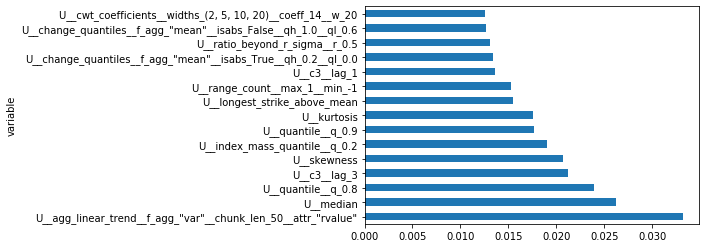

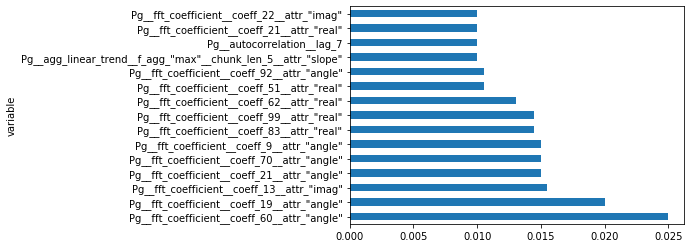

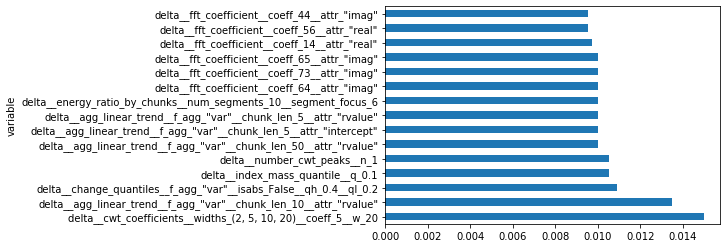

In [201]:
most_valuable_feat = dict([[feat, None] for feat in features])
for param in features:
    most_valuable_feat[param] = (plot_features(modified_features[param], labels.label))

In [224]:
# Создаем датафрэйм с индексами, который будем доплнять самыми релевантными фичами
def remain_relevant_features(features):
    resulted_df = pd.DataFrame(index=features['U'].index)
    # Дополняем датафрэйм
    for param in features:
        for feat in features[param]:
            if feat in most_valuable_feat[param]:
                if most_valuable_feat[param][feat] >= 0.015:
                    resulted_df = resulted_df.join(features[param][feat])
    return resulted_df

In [225]:
# Выведем первые две строки получившегося датафрэйма
resulted_df = remain_relevant_features(features)
resulted_df.head(2)

,"U__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""",U__c3__lag_3,U__index_mass_quantile__q_0.2,U__kurtosis,U__longest_strike_above_mean,U__median,U__quantile__q_0.8,U__quantile__q_0.9,U__range_count__max_1__min_-1,U__skewness,"Pg__fft_coefficient__coeff_13__attr_""imag""","Pg__fft_coefficient__coeff_19__attr_""angle""","Pg__fft_coefficient__coeff_21__attr_""angle""","Pg__fft_coefficient__coeff_60__attr_""angle""","Pg__fft_coefficient__coeff_70__attr_""angle""","Pg__fft_coefficient__coeff_9__attr_""angle""","delta__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_20"
id,,,,,,,,,,,,,,,,,
0,0.222634,-0.549342,0.184080,-0.798970,117.0,0.323020,0.905293,1.065417,130.0,-0.693116,-12.727322,-100.458509,-53.511896,-45.909968,-37.925246,-113.347418,-1.264867
1,0.229270,-0.442796,0.169154,-0.954673,112.0,0.223524,0.959801,1.098430,129.0,-0.562546,-12.354130,-85.904204,-68.306314,-39.982678,-31.094222,-100.011497,-1.379780


In [226]:
print("Оставшиеся фичи:")
print(*resulted_df.columns, sep='\n')

Оставшиеся фичи:
U__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"
U__c3__lag_3
U__index_mass_quantile__q_0.2
U__kurtosis
U__longest_strike_above_mean
U__median
U__quantile__q_0.8
U__quantile__q_0.9
U__range_count__max_1__min_-1
U__skewness
Pg__fft_coefficient__coeff_13__attr_"imag"
Pg__fft_coefficient__coeff_19__attr_"angle"
Pg__fft_coefficient__coeff_21__attr_"angle"
Pg__fft_coefficient__coeff_60__attr_"angle"
Pg__fft_coefficient__coeff_70__attr_"angle"
Pg__fft_coefficient__coeff_9__attr_"angle"
delta__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_20


Построим тепловую карту фич, взятых из предыдущего шага

In [227]:
# data = features['U'].iloc[:,0:50].join(labels.loc[:,['label']], on='id')

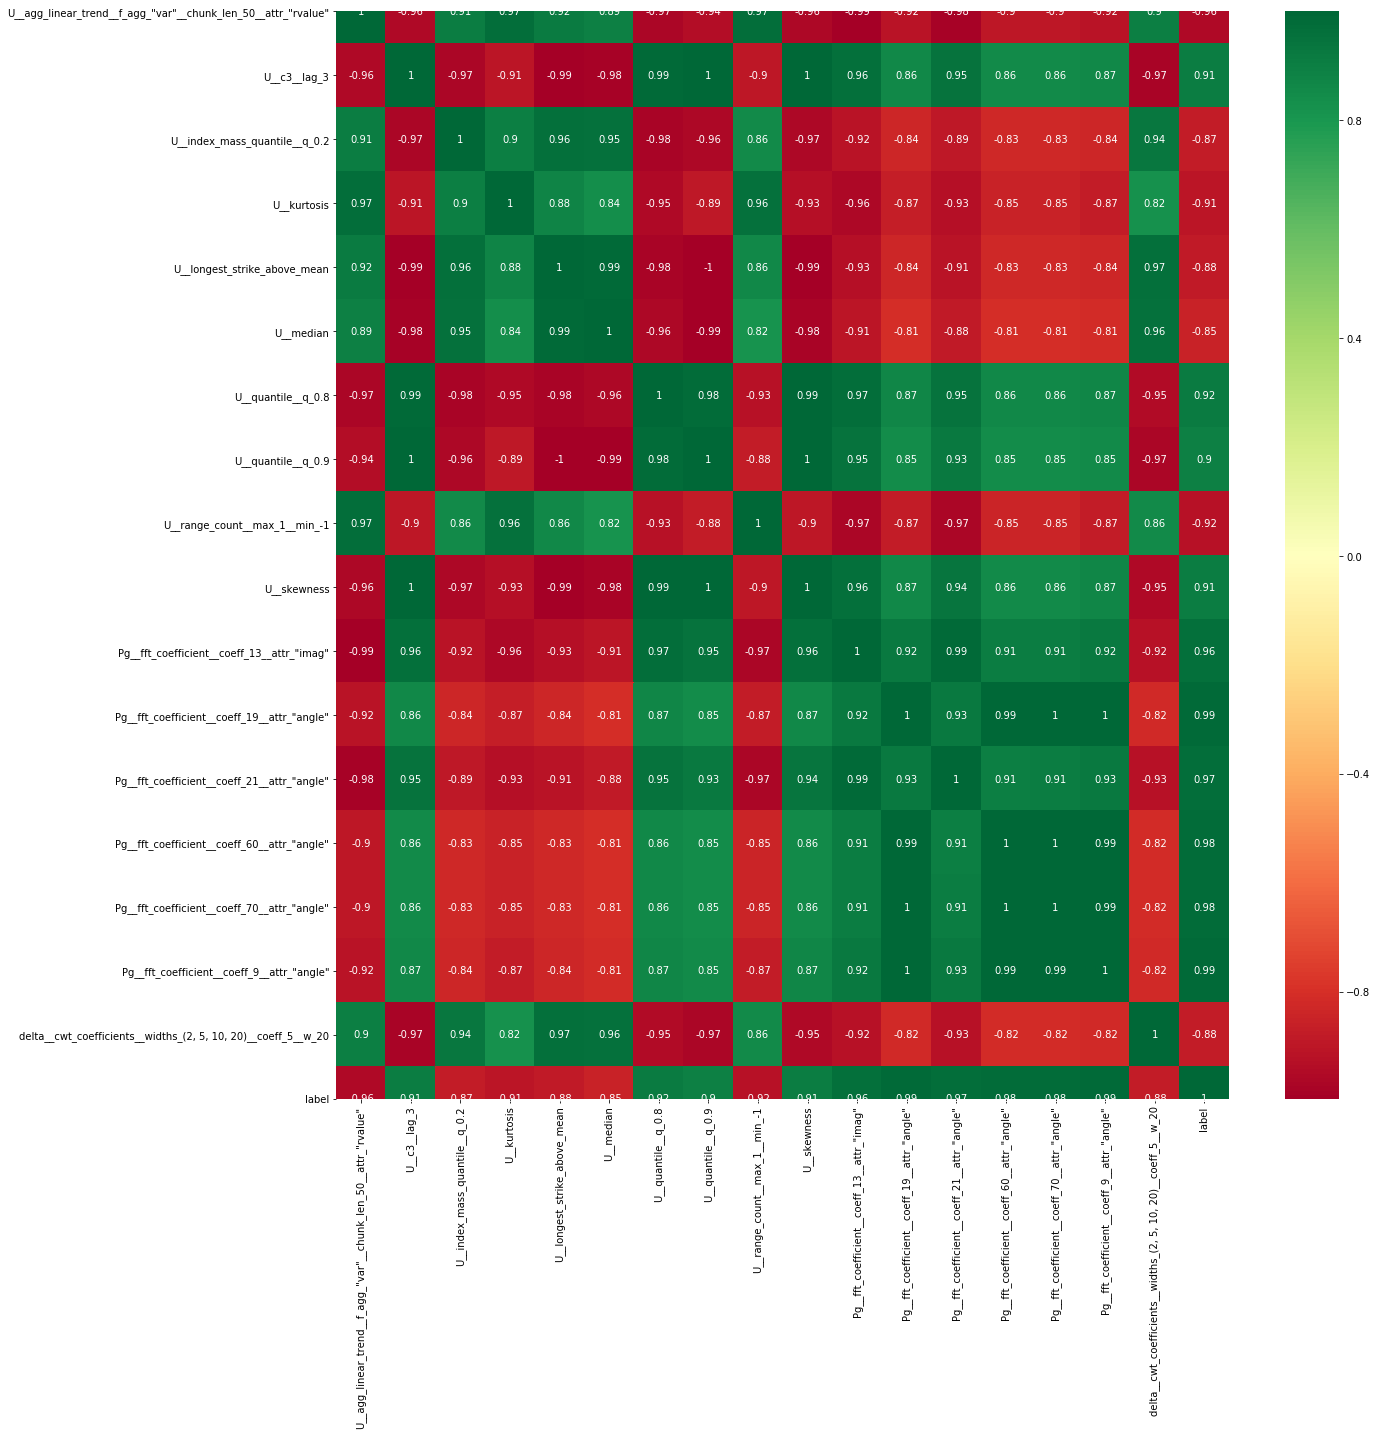

In [228]:
## get correlations of each features in dataset
data = resulted_df.join(labels.loc[:,['id', 'label']])
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Постоение простейших моделей, градиентный бустинг и ансамбль решающих деревьев

In [229]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [230]:
X_train, X_test, y_train, y_test = train_test_split(resulted_df, labels.label, test_size=0.2, random_state=42)

### Ансамбль решающих деревьев

In [231]:
clf = RandomForestClassifier(n_estimators=200, max_depth=5, max_features=0.7)
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
scores

array([1., 1., 1., 1., 1.])

In [232]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [233]:
y_pred = clf.predict_proba(X_test)
y_scores = y_pred[:,1]
y_scores

array([0.725, 0.   , 0.01 , 1.   , 1.   , 1.   , 0.01 , 1.   ])

In [234]:
y_true = np.array(y_test)
metrics.roc_auc_score(y_true, y_scores)

1.0

## Проверка на другом генераторе, который модель никогда ранее не видела

In [240]:
resulted_df_val = remain_relevant_features(features_val)
labels_2.label = pd.to_numeric(labels_2.label)
X_val, y_val = resulted_df_val, labels_2.label
y_pred = clf.predict_proba(X_val)
y_scores = y_pred[:,1]
y_predicted_class = clf.predict(X_val)
print(y_scores)
y_predicted_class

[0.    0.    0.    0.    0.025 0.36  0.    0.4   0.45  0.5   0.    0.
 0.    0.    0.51  0.85  0.85  0.85  0.85  0.85  0.545 0.85  0.855 0.595
 0.675 0.735 0.8  ]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [237]:
y_true = np.array(y_val)
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [238]:
print("ROC AUC score:", metrics.roc_auc_score(y_true, y_scores))
print("F1 score:", metrics.f1_score(y_true, y_predicted_class))

ROC AUC score: 0.9176470588235294
F1 score: 0.8695652173913044


### Градиентный бустинг

In [217]:
clf = GradientBoostingClassifier(learning_rate=0.01, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
scores

array([1., 1., 1., 1., 1.])

In [218]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [219]:
y_pred = clf.predict_proba(X_test)
y_scores = y_pred[:,1]
y_scores

array([0.67762781, 0.18978865, 0.18978865, 0.82281622, 0.82281622,
       0.82281622, 0.18978865, 0.82281622])

In [220]:
y_true = np.array(y_test)
metrics.roc_auc_score(y_true, y_scores)

1.0

## Проверка градиентного бустинга

In [221]:
resulted_df_val = remain_relevant_features(features_val)
labels_2.label = pd.to_numeric(labels_2.label)
X_val, y_val = resulted_df_val, labels_2.label
y_pred = clf.predict_proba(X_val)
y_scores = y_pred[:,1]
y_predicted_class = clf.predict(X_val)
y_scores

array([0.18978865, 0.18978865, 0.18978865, 0.18978865, 0.18978865,
       0.33833119, 0.18978865, 0.33833119, 0.47787319, 0.47787319,
       0.18978865, 0.18978865, 0.18978865, 0.18978865, 0.47787319,
       0.66909369, 0.66909369, 0.66909369, 0.66909369, 0.66909369,
       0.47787319, 0.66909369, 0.66909369, 0.54856199, 0.58540593,
       0.58540593, 0.66909369])

In [222]:
y_true = np.array(y_val)
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [223]:
print("ROC AUC score:", metrics.roc_auc_score(y_true, y_scores))
print("F1 score:", metrics.f1_score(y_true, y_predicted_class))

ROC AUC score: 0.9088235294117647
F1 score: 0.8571428571428572


Гит комит

In [140]:
!git status
!git add .
!git commit -m "Added another generator"


error: key does not contain a section: name
error: key does not contain a section: email
error: key does not contain a section: name
error: key does not contain a section: email
On branch master
Your branch is up-to-date with 'origin/master'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)

	modified:   Data_forming.ipynb
	modified:   Data_processing.ipynb
	deleted:    data/le_8/1.TXT
	deleted:    data/le_8/1.csv
	deleted:    data/le_8/10.TXT
	deleted:    data/le_8/10.csv
	deleted:    data/le_8/11.TXT
	deleted:    data/le_8/11.csv
	deleted:    data/le_8/12.TXT
	deleted:    data/le_8/12.csv
	deleted:    data/le_8/13.TXT
	deleted:    data/le_8/13.csv
	deleted:    data/le_8/14.TXT
	deleted:    data/le_8/14.csv
	deleted:    data/le_8/15.TXT
	deleted:    data/le_8/15.csv
	deleted:    data/le_8/16.TXT